In [98]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Load in Data From pickle file

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning) 

with open('feature.pkl', 'rb') as f:
    data = pickle.load(f)

data = data.drop_duplicates(subset = 'material_id')
tab = data.drop(['Formula', 'Mag_atom', 'Near_Distance', 'Tc_std','material_id','SGR'],axis = 1)
tab = tab.dropna(axis = 0)

### Produce X (features) and Y (label) table

In [2]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(copy = True, with_mean = True, with_std = True)

for i in range(tab.shape[1]):
    feature = np.array(tab.iloc[:,i]).reshape(tab.shape[0],1)
    tab.iloc[:,i] = scalar.fit_transform(feature)

tab = tab.sample(frac = 1, random_state = 5).reset_index(drop = True)
X = tab.drop('Tc_avg', axis = 1)
Y = pd.DataFrame(tab['Tc_avg'])

### Apply t- SNE on X table: mapping high dimensional data onto 2 dimension plan

In [3]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

X_embedded = TSNE(n_components = 2, random_state = 13).fit_transform(X)

### Apply K means to the t-SNE mapping

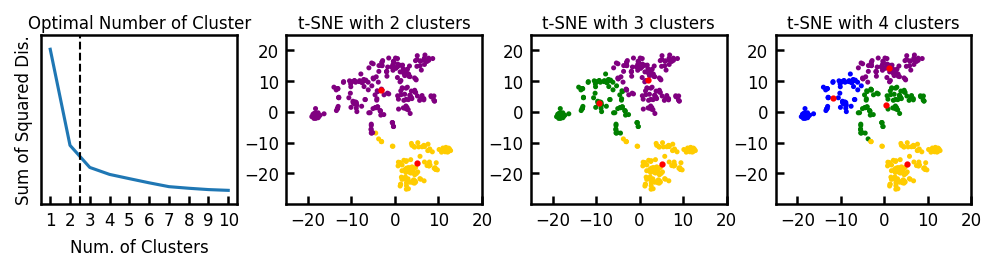

In [14]:
from sklearn.cluster import KMeans

def decoration(ax, title =""):
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)     
    ax.tick_params(labelsize = 8, which = "major", length = 4, width = 1.2, direction = 'in')
    ax.set_title(title, fontsize = 8, pad = 3)
    
def pickColor(clusters):
    color_list = ['purple', '#ffcc00', 'green', 'b']
    colors = []
    for i in clusters:
        colors.append(color_list[i])
    return colors


fig = plt.figure(figsize = (8, 1.5), dpi = 150)
lables = []
for i in range(1, 4):
    ax = plt.subplot(1, 4, i + 1)
    kmeans = KMeans(n_clusters = i + 1, random_state = 0).fit(X_embedded)
    cluster_center = kmeans.cluster_centers_    
    clusters = kmeans.predict(X_embedded)
    lables.append(clusters);
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s = 2, c = pickColor(clusters))
    ax.scatter(cluster_center[:, 0], cluster_center[:, 1], c = 'r', s = 4)
    ax.set_xlim(-25, 20)
    ax.set_ylim(-30, 25)
    ax.get_xaxis().set_ticks(np.arange(-20, 21, 10))
    ax.get_yaxis().set_ticks(np.arange(-20, 21, 10))
    decoration(ax, "t-SNE with %d clusters"%(i + 1))
    
elbow_curve = []
for i in range(10):
    kmeans = KMeans(n_clusters = i + 1, random_state = 0).fit(X_embedded)
    elbow_curve.append(kmeans.inertia_)

ax = plt.subplot(1, 4, 1)
ax.plot(np.arange(1, 11), elbow_curve/elbow_curve[0])
ax.plot([2.5, 2.5], [-0.05, 1.1], '--k', linewidth = 1)
ax.set_ylim(-0.05, 1.1)
ax.set_xlabel("Num. of Clusters", fontsize = 8)
ax.set_ylabel("Sum of Squared Dis.", fontsize = 8)
ax.get_xaxis().set_ticks(np.arange(1, 11))
ax.get_yaxis().set_ticks([])
decoration(ax, "Optimal Number of Cluster")
plt.subplots_adjust(wspace = 0.25, hspace = 0.2)

### Number of training example in each clustering group

In [5]:
for i, lable in enumerate(lables):
    print("For %d group clustering" %(i + 2))
    for j in range(0, i + 2):
        size = np.count_nonzero(lable == j)
        print("\t%d sample in %d-th group" %(size, j + 1))
        
tab['group'] = lables[1]

For 2 group clustering
	216 sample in 1-th group
	101 sample in 2-th group
For 3 group clustering
	119 sample in 1-th group
	100 sample in 2-th group
	98 sample in 3-th group
For 4 group clustering
	71 sample in 1-th group
	99 sample in 2-th group
	80 sample in 3-th group
	67 sample in 4-th group


In [11]:
from sklearn.ensemble import RandomForestRegressor
from termcolor import colored

parameters = [[6, 2, 390], [30, 2, 100], [6, 4, 7], [10, 4, 100]]
colors = ["magenta", "yellow", "green", None]
group_name = ["Purple cluster", "Yellow cluster", "Green cluster", "Whole Dataset"]

feature_importances = []

for i, parameter in enumerate(parameters):
    RFR_model = RandomForestRegressor(max_depth = 6, random_state = 3, n_estimators = 390)
    if(i != 3):
        group = tab[tab['group'] == i]
        X = group.drop(['Tc_avg', 'group'], axis = 1)
        Y = pd.DataFrame(group['Tc_avg'])
    else:
        X = tab.drop(['Tc_avg', 'group'], axis = 1)
        Y = pd.DataFrame(tab['Tc_avg'])
    RFR_model.fit(X, Y)
    importance = RFR_model.feature_importances_
    feature_importances.append(importance)
    ind = importance.argsort()[::-1][:4]
#     ind = importance.argsort()[::-1]
    print("For the examples in %s, the 4 most importance features from high to low are" % colored(group_name[i], colors[i]))
    for num in ind:
        print("\t%s, feature importance %.3f" 
             %('\033[1m' + X.columns[num] +'\033[0m', importance[num]))
    print()



For the examples in Purple cluster, the 4 most importance features from high to low are
	Coordnate_Number, feature importance 0.257
	Fe_dDOS, feature importance 0.153
	lattice_a, feature importance 0.145
	Bound_Length, feature importance 0.107

For the examples in Yellow cluster, the 4 most importance features from high to low are
	Bound_Length, feature importance 0.396
	Magnetic_moment, feature importance 0.170
	Tol_DOS, feature importance 0.105
	lattice_c, feature importance 0.071

For the examples in Green cluster, the 4 most importance features from high to low are
	Coordnate_Number, feature importance 0.582
	Bound_Length, feature importance 0.149
	Co_dDOS, feature importance 0.092
	lattice_b, feature importance 0.041

For the examples in Whole Dataset, the 4 most importance features from high to low are
	Coordnate_Number, feature importance 0.380
	Bound_Length, feature importance 0.135
	lattice_b, feature importance 0.086
	lattice_a, feature importance 0.076



### Split Data Into Three Groups and Evaluate their Performance Separately

In [120]:
pd.options.display.max_colwidth = 700
Model_perfomance = pd.DataFrame({"Support Vector Reg.":[0.16, 0.266, 0.646, 0.4058], 
                                 "Kernel Ridge Reg.": [0.243, 0.414, 0.560, 0.4795],
                                 "Random Forest Reg.": [0.313, 0.355, 0.669, 0.4846 ],
                                 "Gradient Boosting Reg.": [0.262, 0.391, 0.660, 0.4954],
                                 "Bagging":[0.389, 0.434, 0.715, 0.518],
                                 "Stacking":[0.404, 0.444, 0.715, 0.520],
                                 "Bagging Models":["KRR, RFR", "ALL", "SVR, RFR, GBR", "KRR, RFR, GBR"],
                                 "Stacking Models":["KRR, RFR", "ALL", "SVR, GBR", "KRR, RFR, GBR"]},
                                  index = ["Purple Group", "Yellow Group", "Green Group", "Whole Dataset"])

Model_perfomance

,Support Vector Reg.,Kernel Ridge Reg.,Random Forest Reg.,Gradient Boosting Reg.,Bagging,Stacking,Bagging Models,Stacking Models
Purple Group,0.1600,0.2430,0.3130,0.2620,0.389,0.404,"KRR, RFR","KRR, RFR"
Yellow Group,0.2660,0.4140,0.3550,0.3910,0.434,0.444,ALL,ALL
Green Group,0.6460,0.5600,0.6690,0.6600,0.715,0.715,"SVR, RFR, GBR","SVR, GBR"
Whole Dataset,0.4058,0.4795,0.4846,0.4954,0.518,0.520,"KRR, RFR, GBR","KRR, RFR, GBR"


In [128]:
colors = ["#990099", "#ffcc00", "#00b33c", 'black']
group_name = ["First", "Second", "Third", "Whole"]

features = ['Tol. DOS', 'Fe dDOS', 'Cr dDOS', 'Mn dDOS', 'Co dDOS',
'Coor. Num.', 'Mag. Mom.', 'Bnd. Leng.', 'lattice a',
 'lattice b', 'lattice c',  "Angle " + r'$\alpha$',"Angle " + r'$\beta$', "Angle " + r'$\gamma$']

models = ['SVR', 'KRR', 'RFR', 'GBR', 'Bagging', 'Stacking']

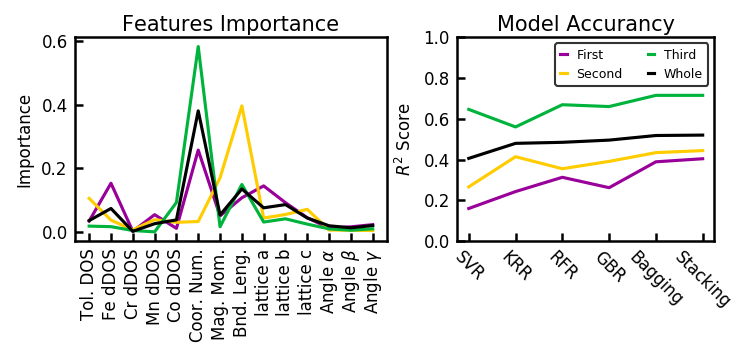

In [130]:
fig = plt.figure(figsize = (5.5, 1.8), dpi = 150)
fig = plt.GridSpec(1, 12)
ax1 = plt.subplot(fig[0, :6])
ax2 = plt.subplot(fig[0, 7:])

for i, line in enumerate(feature_importances):
    ax1.plot(line, color = colors[i], linewidth = 1.5)
    ax2.plot(Model_perfomance.iloc[i, :-2], color = colors[i], label = group_name[i])

# decoration(ax2)
ax1.set_ylabel("Importance", fontsize = 8)
ax2.set_ylabel("$R^2$ Score", fontsize = 8)


ax1.set_xticks(np.arange(0, 14))
ax2.set_xticks(np.arange(0, 6))  
ax1.set_xticklabels(features, rotation = 90)
ax2.set_xticklabels(models, rotation = 315)
ax2.legend(loc = 1, fontsize = 6, handlelength = 0.5, edgecolor = 'k', ncol = 2)
ax2.set_ylim(0, 1)

decoration(ax1)
decoration(ax2)
ax1.set_title("Features Importance", fontsize = 10, pad = 3)
ax2.set_title("Model Accurancy", fontsize = 10, pad = 3)
plt.subplots_adjust(wspace = 0.4)

In [ ]:
T test on different group